# Prepare data

In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# !pip install fastai --upgrade
# from fastai.data.external import untar_data, URLs

!pip install lpips #for LPIPS


     |████████████████████████████████| 53 kB 1.5 MB/s 


In [ ]:
                                                                                                                       

# for file in train_paths:
#   !cp $file "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff8000"

# for file in val_paths:
#   !cp $file "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000"    

For getting the images
1. https://drive.google.com/drive/folders/1P-n6N4xPw7kv-hB2hxl0QU0K3ANpC9AK?usp=sharing #path1, train x
2. https://drive.google.com/drive/folders/1XPLoJ_I4-48IiqLsE2ZuUgfbHaQoU75O?usp=sharing #path2, train y 
3. https://drive.google.com/drive/folders/1y2d93BepUDbP5wYY-HFWd2ij1toYCIGG?usp=sharing #path3, validation x
4. https://drive.google.com/drive/folders/1mkQa8m5RP6NJCr19hLbEiZnexyDwXLMx?usp=sharing #path4, validation y

In [ ]:
path1 = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff8000" #train x - pre colored image
path2 = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/cocostuff8000" # train y - ground truth
path3 = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000output" #validation x
path4 = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000" # validation y

train_paths_x = sorted(glob.glob(path1 + "/*.png")) # pre-colored images as input; use sorted to keep the sequence of file names, otherwise the x and y doesn't match
train_paths_y = sorted(glob.glob(path2 + "/*.jpg")) # the original image as ground truth

validation_paths_x = sorted(glob.glob(path3 + "/*.png"))
validation_paths_y = sorted(glob.glob(path4 + "/*.jpg"))


print(len(train_paths_x), len(train_paths_y), len(validation_paths_x), len(validation_paths_y))


8000 8000 2000 2000


In [ ]:
# for presentation in poster
path3 = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000output" #validation x
path4 = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000" # validation y

items = ['000000358268', '000000389977', '000000147142', '000000171360', '000000162164',
         '000000257629', '000000207205']
poster_path_y = []
poster_path_x = []
for item in items:
  poster_path_x.append(path3+'/'+item+'.png')
  poster_path_y.append(path4+'/'+item+'.jpg')
print(poster_path_x)

['/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000output/000000358268.png', '/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000output/000000389977.png', '/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000output/000000147142.png', '/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000output/000000171360.png', '/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000output/000000162164.png', '/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000output/000000257629.png', '/content/drive/MyDrive/02456 Deep Learning - Image Colorization/InstColorization/test/cocostuff2000output/000000207205.png']


In [ ]:
# Check that all file names match
count = 0 
for i in range(len(train_paths_x)):
  if (train_paths_x[i].split("/")[8].split(".")[0] != train_paths_y[i].split("/")[7].split(".")[0]):
    print(train_paths_x[i].split("/")[8].split(".")[0]) 
    print(train_paths_y[i].split("/")[7].split(".")[0])
    count+=1
for i in range(2000):
  if (validation_paths_x[i].split("/")[8].split(".")[0] != validation_paths_y[i].split("/")[8].split(".")[0]):
    print(validation_paths_x[i].split("/")[8].split(".")[0]) 
    print(validation_paths_y[i].split("/")[8].split(".")[0])
    count+=1

print(count)

0


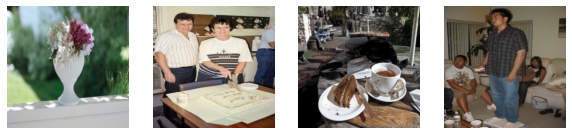

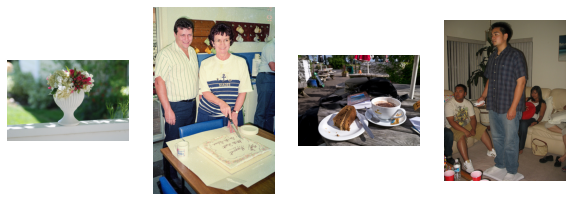

In [ ]:
_, axes = plt.subplots(1, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths_x):
    ax.imshow(Image.open(img_path))
    ax.axis("off")
_, axes = plt.subplots(1, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths_y):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

# Make dataloader

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths1, paths2, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths1 = paths1
        self.paths2 = paths2
    
    def __getitem__(self, idx):
        img_x = Image.open(self.paths1[idx]).convert("RGB")
        img_x = self.transforms(img_x)
        img_x = np.array(img_x)
        img_lab_x = rgb2lab(img_x).astype("float32") # Converting RGB to L*a*b
        img_lab_x = transforms.ToTensor()(img_lab_x)
        L_x = img_lab_x[[0], ...] / 50. - 1. # Between -1 and 1
        ab_x = img_lab_x[[1, 2], ...] / 110. # Between -1 and 1

        img_y = Image.open(self.paths2[idx]).convert("RGB")
        img_y = self.transforms(img_y)
        img_y = np.array(img_y)
        img_lab_y = rgb2lab(img_y).astype("float32") # Converting RGB to L*a*b
        img_lab_y = transforms.ToTensor()(img_lab_y)
        L_y = img_lab_y[[0], ...] / 50. - 1. # Between -1 and 1
        ab_y = img_lab_y[[1, 2], ...] / 110. # Between -1 and 1
        
        
        return {'L_x': L_x, 'ab_x': ab_x, 'L_y': L_y, 'ab_y': ab_y}
    
    def __len__(self):
        return len(self.paths1)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths1=train_paths_x, paths2=train_paths_y, split='train')
val_dl = make_dataloaders(batch_size=1, paths1=validation_paths_x, paths2=validation_paths_y, split='val')

data = next(iter(val_dl))
x1, y1, x2, y2 = data['L_x'], data['ab_x'], data['L_y'], data['ab_y']
print(x1.shape, y1.shape, x2.shape, y2.shape)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])


In [ ]:
poster_dl = make_dataloaders(batch_size=1, paths1=poster_path_x, paths2=poster_path_y, split='val')

# UNet

In [ ]:
from torch import nn, optim
import torch
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=2, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
Unet(2)

Unet(
  (model): UnetBlock(
    (model): Sequential(
      (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

#Initialization

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

model = Unet()
model = init_model(model, 'cuda') 

model initialized with norm initialization


#Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.SmoothL1Loss(beta=1.0) # smooth L1 loss, cannot be changed 

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # L2 regularization weight_decay=1e-5

#Training

In [ ]:
def train_model(model, train_dl, epochs, display_every=20):
    train_loss = []
    val_loss = []
    for e in range(epochs):
        training_loss = 0.0
        validation_loss = 0.0
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            x = data['ab_x'].to(model.device)       
            y = data['ab_y'].to(model.device)  
            optimizer.zero_grad()
            output = model.forward(x)             
            
            batch_loss = criterion(output,y)           
            batch_loss.backward()
            optimizer.step()  
            training_loss += batch_loss
            i += 1
            # if i % display_every == 0:
            #     print(f"\nEpoch {e+1}/{epochs}")
            #     print(f"Iteration {i}/{len(train_dl)}")
            #     print('batch loss=',batch_loss)
            #     print('running loss=',running_loss)
        # train_loss.append(training_loss)

    #     for data in tqdm(val_dl):
    #         x = data['ab_x'].to(model.device)       
    #         y = data['ab_y'].to(model.device)  
           
    #         output = model(x)            
            
    #         batch_loss = criterion(output,y) 
    #         validation_loss += batch_loss

    #     val_loss.append(validation_loss)

        print(f"\nEpoch {e+1}/{epochs}")
        print(f"Iteration {i}/{len(train_dl)}")
        print('batch loss=',batch_loss)
        print('training loss=',training_loss)
        # print('validation loss=',validation_loss)
    
    # # Plot training and validation loss
    # import matplotlib.pyplot as plt
    # %matplotlib inline
    # epoch = np.arange(len(train_loss))
    # plt.figure()
    # plt.plot(epoch, train_loss, 'r', label='Training loss',)
    # plt.plot(epoch, val_loss, 'b', label='Validation loss')
    # plt.legend()
    # plt.xlabel('Epoch'), plt.ylabel('NLL')
    # plt.show()
        
 

train_model(model, train_dl, 20)
      

# Using ResNet18 as backbone for UNet

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_res_unet(n_input=2, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

Pre-training 

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for e in range(epochs):
        running_loss = 0.0
        for data in tqdm(train_dl):
            x = data['ab_x'].to(device)       
            y = data['ab_y'].to(device) 
            preds = net_G(x)
            loss = criterion(preds, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
         
            running_loss += loss
            
        print(f"Epoch {e + 1}/{epochs}")
        print("Loss: ", running_loss)
        torch.save(net_G.state_dict(), "res18-unet-latest.pt")

net_G = build_res_unet(n_input=2, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
#pretrain_generator(net_G, train_dl, opt, criterion, 20)
#torch.save(net_G.state_dict(), "res18-unet.pt")

In [ ]:
#train model using resnet weights
PATH = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/res18-unet.pt"
model = Unet()
model.to('cuda')
model.load_state_dict(torch.load("res18-unet.pt"))
train_model(model, train_dl, 20)


In [ ]:
import os
os.chdir("/content/drive/MyDrive/02456 Deep Learning - Image Colorization")
!ls

# Save model

reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training

In [ ]:
PATH = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/mymodel-1203-smoothL1-withWeightDecay-lr0.01-kaiming.pth"
torch.save(model.state_dict(), PATH)

#Utils

In [ ]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images   """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).detach().numpy()    
    img_rgb = lab2rgb(Lab)
  
    return img_rgb

PSNR, SSIM and LPIPS

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
def PSNR(other, real):    
    return psnr(other, real, data_range=real.max() - real.min())

In [ ]:
from skimage.metrics import structural_similarity as ssim
def SSIM(other,real):
 return ssim(other, real, data_range=real.max() - real.min(), multichannel=True)

In [ ]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') #best forward scores
def LPIPS(other, real):
  other = other.permute(2,0,1)
  other = other[None, :, :, :]

  real = real.permute(2,0,1)
  real = real[None, :, :, :]
  
  
  return loss_fn_alex(other, real)



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
#try reshape
a = torch.zeros(1,3,64,64)
print(a.shape)
b = torch.zeros(256,200,3)
b = b.permute(2,0,1)
x = b[None, :, :, :]
print(b.shape)
print(x.shape)

torch.Size([1, 3, 64, 64])
torch.Size([3, 256, 200])
torch.Size([1, 3, 256, 200])


#Test

Download the saved weights

In [16]:
!gdown --id 1tN9ETzfEqLZwFhdroB6ER__tLIBRxGUI #smoothL1-withWeightDecay-lr0.0001
!gdown --id 1-6-R1d0VtgZv32oDoCzJl5WGQiT5q_yJ #smoothL1-withoutWeightDecay
!gdown --id 1-2M3R1UdLjK4pgTD763GDG_EFTLwMd8C #L1Loss
!gdown --id 1-03KDt5tdNiyvQtpwRT5TQkmRpOp1kp9 #smoothL1-withWeightDecay-lr0.001


Downloading...
From: https://drive.google.com/uc?id=1tN9ETzfEqLZwFhdroB6ER__tLIBRxGUI
To: /content/mymodel-1122-withUnet-8000-smoothL1-withWeightDecay-lr0.0001.pth
100% 218M/218M [00:01<00:00, 193MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6-R1d0VtgZv32oDoCzJl5WGQiT5q_yJ
To: /content/mymodel-1121-withUnet-8000-smoothL1-withoutWeightDecay.pth
100% 218M/218M [00:01<00:00, 201MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-2M3R1UdLjK4pgTD763GDG_EFTLwMd8C
To: /content/mymodel-1121-withUnet-with8000-L1Loss.pth
100% 218M/218M [00:01<00:00, 187MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-03KDt5tdNiyvQtpwRT5TQkmRpOp1kp9
To: /content/mymodel-1121-withUnet-with8000.pth
100% 218M/218M [00:01<00:00, 196MB/s]


Load model

In [ ]:
PATH = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/mymodel-1121-withUnet-8000-smoothL1-withoutWeightDecay.pth"  #change the path to the downloaded weights if needed

# !gdown --id 1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV
model = Unet()
model.to('cuda')
model.load_state_dict(torch.load(PATH))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

i=0
psnr1 = 0
ssim1 = 0
psnr2 = 0
ssim2 = 0
lpips1 = 0
lpips2 = 0
for data in tqdm(val_dl):
  i+=1
  # print(i)
  # fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  x_ab = data['ab_x']
  x_L = data['L_x']
  input_img = torch.from_numpy(lab_to_rgb(x_L, x_ab)[0])
  # ax1.imshow(input_img)
  # ax1.set_title('Input')
  y_ab = data['ab_y']
  y_L = data['L_y']
  
  x_ab = x_ab.to(device)
  output = model(x_ab) 

  predicted_img = lab_to_rgb(x_L, output.to('cpu'))[0]
  # ax2.imshow(predicted_img)
  # ax2.set_title('Predicted')

  real_img = lab_to_rgb(y_L, y_ab)[0]
  # ax3.imshow(real_img)
  # ax3.set_title('Ground truth')

  input_img = input_img.numpy()
  psnr1 += PSNR(input_img, real_img)
  ssim1 += SSIM(input_img, real_img)
  lpips1 += LPIPS(torch.from_numpy(input_img), torch.from_numpy(real_img))

  psnr2 += PSNR(predicted_img, real_img)
  ssim2 += SSIM(predicted_img, real_img)
  lpips2 += LPIPS(torch.from_numpy(predicted_img), torch.from_numpy(real_img))


  # print(PSNR(input_img, real_img), PSNR(predicted_img, real_img))
  # print(SSIM(input_img, real_img), SSIM(predicted_img, real_img))
  # print(LPIPS(torch.from_numpy(input_img), torch.from_numpy(real_img)), LPIPS(torch.from_numpy(predicted_img), torch.from_numpy(real_img)))
  # plt.show()
  if (i % 100 == 0):
    print('PSNR mean until now: ',psnr1/i,psnr2/i)
    print('SSIM mean until now: ',ssim1/i,ssim2/i)
    print('LPIPS mean until now: ',lpips1.item()/i,lpips2.item()/i)

print('PSNR mean until now: ',psnr1/i,psnr2/i)
print('SSIM mean until now: ',ssim1/i,ssim2/i)
print('LPIPS mean until now: ',lpips1.item()/i,lpips2.item()/i)




Example pictures for the poster

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1514 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


28.73359356633969 17.39796133582028
0.930700905848099 0.359922436152371
tensor([[[[0.0754]]]], grad_fn=<AddBackward0>) tensor([[[[0.3350]]]], grad_fn=<AddBackward0>)


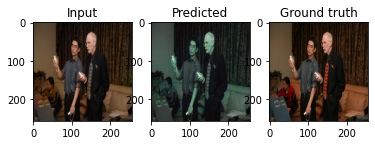

2


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 163 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


26.819588291919388 14.680186395702513
0.9347263421722566 0.4405999146410496
tensor([[[[0.0741]]]], grad_fn=<AddBackward0>) tensor([[[[0.3394]]]], grad_fn=<AddBackward0>)


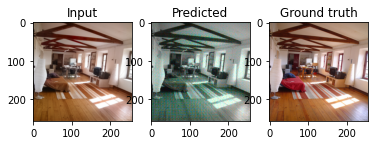

3


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 304 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


28.084982421183188 15.715362724643931
0.9366706974993648 0.39770363189701213
tensor([[[[0.0951]]]], grad_fn=<AddBackward0>) tensor([[[[0.4074]]]], grad_fn=<AddBackward0>)


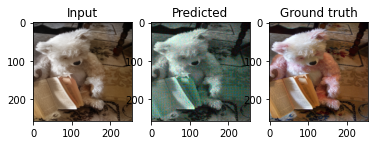

4


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 206 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


26.070904651068613 15.881112610980646
0.9498932131117425 0.5906900299420627
tensor([[[[0.0937]]]], grad_fn=<AddBackward0>) tensor([[[[0.1937]]]], grad_fn=<AddBackward0>)


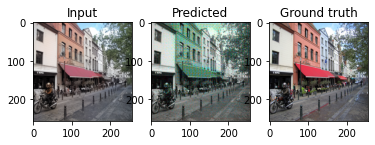

5


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 648 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


22.441962797585337 15.47350842005961
0.9083863113337772 0.44935132182186815
tensor([[[[0.1117]]]], grad_fn=<AddBackward0>) tensor([[[[0.3320]]]], grad_fn=<AddBackward0>)


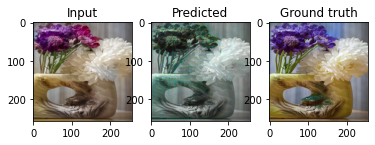

6


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 169 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


24.321595704248328 15.177052618982634
0.9228407766647639 0.49188353328926987
tensor([[[[0.0752]]]], grad_fn=<AddBackward0>) tensor([[[[0.2372]]]], grad_fn=<AddBackward0>)


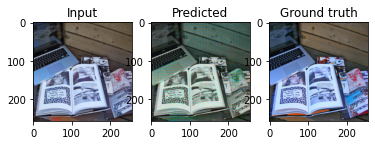

7


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 360 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


22.796366067562595 15.033334997437706
0.9005394165780464 0.424948332549455
tensor([[[[0.1578]]]], grad_fn=<AddBackward0>) tensor([[[[0.3455]]]], grad_fn=<AddBackward0>)


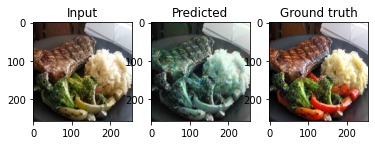

In [ ]:
from PIL import Image
#poster
# PATH = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/mymodel-1121-withUnet-with8000.pth" #lr 0.001, L2 weight decay normal intial 20 epoch 8000images
PATH = "/content/drive/MyDrive/02456 Deep Learning - Image Colorization/mymodel-1121-withUnet-with8000-L1Loss.pth"

model = Unet()
# model.to('cuda')
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

i=0
psnr1 = 0
ssim1 = 0
psnr2 = 0
ssim2 = 0
lpips1 = 0
lpips2 = 0
for data in tqdm(poster_dl):
  i+=1
  print(i)
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  x_ab = data['ab_x']
  x_L = data['L_x']
  input_img = torch.from_numpy(lab_to_rgb(x_L, x_ab)[0])
  ax1.imshow(input_img)
  ax1.set_title('Input')
  y_ab = data['ab_y']
  y_L = data['L_y']
  
  x_ab = x_ab.to(device)
  output = model(x_ab) 

  predicted_img = lab_to_rgb(x_L, output.to('cpu'))[0]
  ax2.imshow(predicted_img)
  ax2.set_title('Predicted')

  real_img = lab_to_rgb(y_L, y_ab)[0]
  ax3.imshow(real_img)
  ax3.set_title('Ground truth')

  input_img = input_img.numpy()
  psnr1 += PSNR(input_img, real_img)
  ssim1 += SSIM(input_img, real_img)
  lpips1 += LPIPS(torch.from_numpy(input_img), torch.from_numpy(real_img))

  psnr2 += PSNR(predicted_img, real_img)
  ssim2 += SSIM(predicted_img, real_img)
  lpips2 += LPIPS(torch.from_numpy(predicted_img), torch.from_numpy(real_img))


  print(PSNR(input_img, real_img), PSNR(predicted_img, real_img))
  print(SSIM(input_img, real_img), SSIM(predicted_img, real_img))
  print(LPIPS(torch.from_numpy(input_img), torch.from_numpy(real_img)), LPIPS(torch.from_numpy(predicted_img), torch.from_numpy(real_img)))
  plt.show()

  im =  Image.fromarray((real_img * 255).astype(np.uint8))
  fileName = str(i)+''+'-original.jpg'
  im.save(fileName)


# print('PSNR mean until now: ',psnr1/i,psnr2/i)
# print('SSIM mean until now: ',ssim1/i,ssim2/i)
# print('LPIPS mean until now: ',lpips1.item()/i,lpips2.item()/i)
